# MBTI Prediction

Cécile Gontier - Florimond Manca - Delphine Shi

Nous travaillons sur le dataset Kaggle [(MBTI) Myers-Briggs Personality Type](https://www.kaggle.com/datasnaek/mbti-type) qui regroupe les 50 derniers commentaires d'utilisateurs de personnalités MBTI différentes sur le forum [PersonalityCafe](https://www.personalitycafe.com/forum/).

Le Myers Briggs Type Indicator (MBTI) est un outil d'évaluation psychologique qui sépare les individus en 16 types distincts sur 4 axes :
- Orientation de l'énergie : Introversion (I) – Extroversion (E)
- Recueil d'information : Intuition (N) – Sensation (S)
- Prise de décision : Pensée (T) – Sentiment (F)
- Mode d'action : Jugement (J) – Perception (P)

**L'objectif de ce projet est de déterminer le type d'un individu à partir de ses 50 derniers posts ou tweets.**

## Description

Les différentes étapes que nous avons suivi sont les suivantes :

1. Import des données
1. Analyse graphique des données
1. Rééquilibrage des données par des techniques de resampling
1. Nettoyage des commentaires (text preprocessing) et vectorisation
1. Phase d'apprentissage
1. Evaluation

Commençons par importer les librairies nécessaires :

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import sklearn as sk

Options d'affichage de pandas :

In [2]:
pd.set_option('display.width', 3000)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

## Import des données

In [3]:
data = pd.read_csv("./data/mbti_1.csv", header = 0)

print('Base data has %i rows and %i columns' % (data.shape[0], data.shape[1]))

data.head()


Base data has 8675 rows and 2 columns


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [2]:
#TODO: to be removed

from parser import parse_data

data_parsed = parse_data(data)

data_parsed.head()

,id,type,post
0,0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
320975,0,INFJ,http://www.youtube.com/watch?v=ZRCEq_JFeFM
86750,0,INFJ,http://playeressence.com/wp-content/uploads/20...
329650,0,INFJ,http://discovermagazine.com/2012/jul-aug/20-th...
78075,0,INFJ,Welcome and stuff.


## Dataset Analysis

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt


print("Data shape is: {0}, and has columns {1}".format(data.shape, data.columns))

type_count = data.type.value_counts()

Data shape is: (8675, 2), and has columns Index(['type', 'posts'], dtype='object')


### Distribution of types of dataset users

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


Text(0.5, 1.0, 'Distribution of types of dataset users')

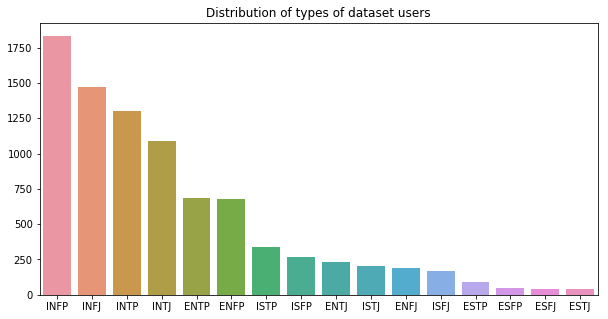

In [5]:
print(type_count)
plt.figure(figsize=(10,5))
sns.barplot(type_count.index, type_count.values)
plt.title('Distribution of types of dataset users')

Here we can see that the population is not equally distributed. We have almost 2000 users of type INFP but less than 50 on ESTJ. It may be representative of the world population, but it means that the prediction will be much more effective for INFP than on ESTJ.

### Number of words in posts by type
It may be interesting to calculate the average number of words by type to see if there is a notable difference.
Inspired by data analysis on https://www.kaggle.com/laowingkin/mbti-study-personality

In [6]:
from parser import parse_posts

def number_words_in_post(post):
    return len(post.split())

data['number_of_words'] = data['posts'].apply(lambda posts: sum([number_words_in_post(post) for post in parse_posts(posts)])/50)

print(data.head())
print(data.groupby(data.type)["number_of_words"].mean())

   type                                              posts  number_of_words
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...            12.10
1  ENTP  'I'm finding the lack of me in these posts ver...            24.38
2  INTP  'Good one  _____   https://www.youtube.com/wat...            17.70
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...            22.26
4  ENTJ  'You're fired.|||That's another silly misconce...            20.32
type
ENFJ    26.688421
ENFP    26.160326
ENTJ    25.312641
ENTP    25.077197
ESFJ    26.750476
ESFP    21.344167
ESTJ    25.551795
ESTP    24.203820
INFJ    26.526925
INFP    25.848035
INTJ    24.831659
INTP    24.904709
ISFJ    25.783012
ISFP    23.664797
ISTJ    25.204585
ISTP    24.267240
Name: number_of_words, dtype: float64


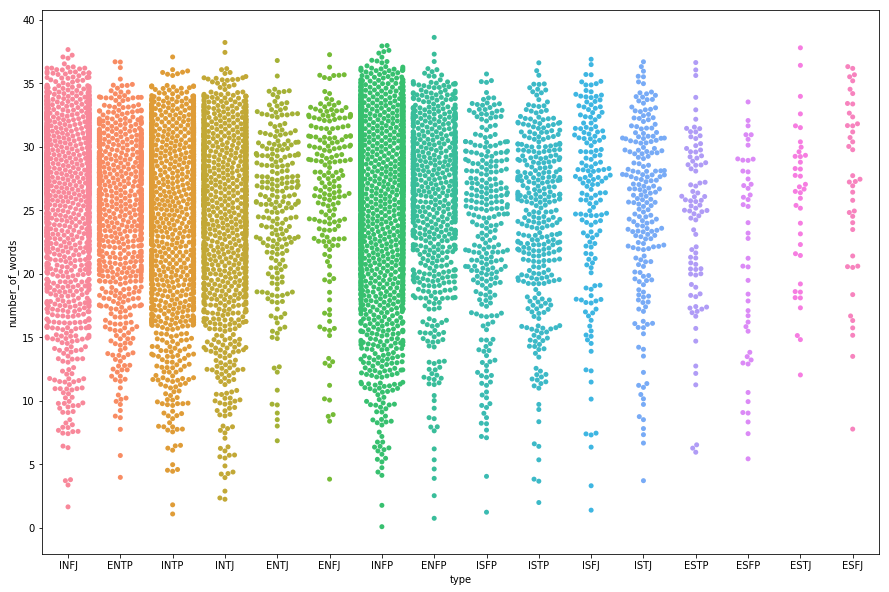

In [7]:
plt.figure(figsize=(15,10))
sns.swarmplot("type", "number_of_words", data=data)

### Vocabulary by type
Here we will analyze the vocabulary used by types of user and see if there is a trend.

In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
  
lemmatizer = nltk.WordNetLemmatizer()
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

def get_vocab(post):
    words = tokenizer.tokenize(post)
    words = [word.lower() for word in words]
    stop_words = set(nltk.corpus.stopwords.words('english')) 
    filtered_sentence = [w for w in words if not w in stop_words]
    lemms = [lemmatizer.lemmatize(word) for word in filtered_sentence]
    return nltk.FreqDist(lemms)


types = data.type.unique()
def get_vocab_type(data):
    for type in types:
        posts = ""
        post = data.loc[data['type'] == type, :]['posts']
        posts = [p for p in post]
        long_post = ". ".join(posts)
        most_common = [word[0] for word in get_vocab(long_post).most_common(10)]
        print("Most common words for type {0} are {1}".format(type, most_common))
        


# print(get_vocab(data.posts[1]).most_common(10))
get_vocab_type(data)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/delphineshi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/delphineshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/delphineshi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Most common words for type INFJ are ['like', 'think', 'people', 'know', 'one', 'infj', 'really', 'thing', 'time', 'would']
Most common words for type ENTP are ['like', 'think', 'people', 'one', 'entp', 'know', 'get', 'would', 'thing', 'really']
Most common words for type INTP are ['like', 'think', 'people', 'one', 'would', 'know', 'intp', 'thing', 'time', 'get']
Most common words for type INTJ are ['like', 'people', 'think', 'one', 'intj', 'would', 'know', 'time', 'thing', 'get']
Most common words for type ENTJ are ['like', 'think', 'people', 'one', 'entj', 'would', 'get', 'know', 'thing', 'type']
Most common words for type ENFJ are ['like', 'think', 'people', 'know', 'really', 'enfj', 'one', 'thing', 'get', 'would']
Most common words for type INFP are ['like', 'think', 'people', 'really', 'one', 'know', 'thing', 'time', 'infp', 'feel']
Most common words for type ENFP are ['like', 'think', 'people', 'enfp', 'know', 'one', 'really', 'thing', 'get', 'time']
Most common words for type ISF

### Categorisation par axe MBTI

Ajoutons des colonnes pour les indicateurs MBTI. On va pour chaque axe catégoriser le type binairement :
- Introversion (I: 0) / Extraversion (E: 1)
- INtuition (N: 0) / Sensation (S: 1)
- Feeling (F: 0) / Thinking (T: 1)
- Judgement (J: 0) / Perception (P: 1)

Cela nous servira pour la suite pour tester des classificateurs sur seulement 2 classes plutôt que 16.

In [5]:
from axisCategories import translate_personality

data_types = data.join(data.apply(lambda row: translate_personality(row), axis=1))
data_types.head()

,type,posts,IE,NS,FT,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0


In [9]:
print(data_types.columns)
print()
print("Introversion (I) – Extroversion (E):\t", data_types['IE'].value_counts()[0], " / ", data_types['IE'].value_counts()[1])
print("Intuition (N) – Sensing (S):\t\t", data_types['NS'].value_counts()[0], " / ", data_types['NS'].value_counts()[1])
print("Feeling (F) – Thinking (T):\t\t", data_types['FT'].value_counts()[0], " / ", data_types['FT'].value_counts()[1])
print("Judging (J) – Perceiving (P):\t\t", data_types['JP'].value_counts()[0], " / ", data_types['JP'].value_counts()[1])


Index(['type', 'posts', 'IE', 'NS', 'FT', 'JP'], dtype='object')

Introversion (I) – Extroversion (E):	 6676  /  1999
Intuition (N) – Sensing (S):		 7478  /  1197
Feeling (F) – Thinking (T):		 4694  /  3981
Judging (J) – Perceiving (P):		 3434  /  5241


Text(0.5, 1.0, 'Distribution across types indicators')

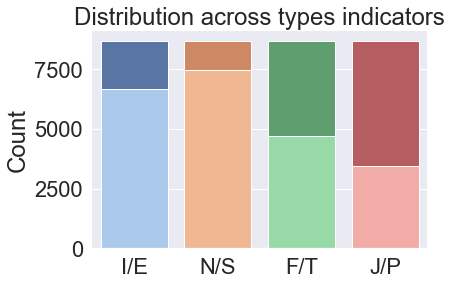

In [10]:
sns.set(font_scale=2)

index = ['I/E', 'N/S', 'F/T', 'J/P']
bottom = (data_types['IE'].value_counts()[0], data_types['NS'].value_counts()[0], data_types['FT'].value_counts()[0], data_types['JP'].value_counts()[0])
top = (data_types['IE'].count(), data_types['NS'].count(), data_types['FT'].count(), data_types['JP'].count())

# Plot 1 - background - "total" (top) series
sns.barplot(x=index, y=top)

# Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x=index, y=bottom, palette="pastel")

# Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel('Count')
bottom_plot.set_title('Distribution across types indicators')



Calculons la corrélation entre les différents axes MBTI avec la Pearson Features Correlation :

In [11]:
data_types[['IE','NS','FT','JP']].corr()

,IE,NS,FT,JP
IE,1.000000,-0.045899,0.069573,0.161939
NS,-0.045899,1.000000,0.080954,0.014922
FT,0.069573,0.080954,1.000000,0.004673
JP,0.161939,0.014922,0.004673,1.000000


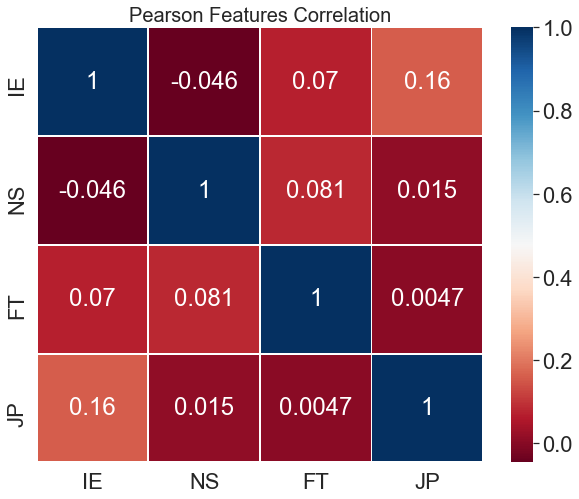

In [12]:
cmap = plt.cm.RdBu
corr = data_types[['IE','NS','FT','JP']].corr()
plt.figure(figsize=(10,8))
plt.title('Pearson Features Correlation', size=20)
sns.heatmap(corr, cmap=cmap, annot=True, linewidths=1)

## Learning

In [4]:
print("Kaggle data size : {}".format(data.shape))
# print(posts.iloc[6376])
# print("Parsed Kaggle data size : {}".format(data_parsed.shape))

class_names = data.type.unique()
print("Labels : {}".format(class_names))


Kaggle data size : (8675, 2)
Labels : ['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


### Tackle imbalanced data issue

As seen in the dataset analysis, our dataset is imbalanced which means our classes are not represented equally. This leads to the accuracy paradox where the accuracy is only reflecting the underlying class distribution. There are several tactics to handle imbalanced data and we are going to try some out.

In [5]:
from resampling import upsample_minority, downsample_majority

data_upsampled = upsample_minority(data)
data_downsampled = downsample_majority(data)


INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64


In [5]:
""" Choose dataset to test on """

dataset = data
# dataset = data_parsed
# dataset = data_upsampled
# dataset = data_downsampled

print('Dataset has %i rows and %i columns' % (dataset.shape[0], dataset.shape[1]))
dataset.head()


Dataset has 8675 rows and 2 columns


### Cross-validation

On sépare le dataset en 2 nouveaux sets, le train set pour entraîner le modèle et le test set pour tester la généralisation du modèle.

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(dataset, test_size=0.4, random_state=0)

print ('Train data has %i rows and %i columns' % (train.shape[0], train.shape[1]))
print ('Test data has %i rows and %i columns' % (test.shape[0], test.shape[1]))

Train data has 5205 rows and 2 columns
Test data has 3470 rows and 2 columns


### Features preprocessing

#### Données manquantes

La première chose à faire est de gérer le problème des données manquantes.

In [7]:
dataset.isnull().sum().sum()

0

Il n'y a aucune donnée manquante dans notre dataset, on peut donc passer au preprocessing des features.

#### Nettoyage des données

On va formatter les posts afin de pouvoir ensuite les vectoriser. Pour cela, on va supprimer les caractères non-alphanumériques, transformer le texte en minuscule, retirer les liens, etc.

**/!\ Cette partie peut prendre longtemps.**

In [10]:
from preprocessing import format_text

train, test = pd.DataFrame(train), pd.DataFrame(test)
%time train['preprocessed_posts'] = train['posts'].apply(format_text)
%time test['preprocessed_posts'] = test['posts'].apply(format_text)

# print(train.head())
# print(test.head())

print('\n\nBefore preprocessing:\n\n', train['posts'].iloc[0][0:500])
print('\n\nAfter preprocessing:\n\n', train['preprocessed_posts'].iloc[0][0:500])

# ATTENTION: supprime les chiffres

CPU times: user 22.3 s, sys: 351 ms, total: 22.6 s
Wall time: 22.8 s
CPU times: user 14.9 s, sys: 135 ms, total: 15.1 s
Wall time: 15.2 s
Before preprocessing:

 'boring|||http://www.youtube.com/watch?v=c1KNZNGT5_w&amp;feature=related mhm|||cap and carpenter's glasses.  48895|||the bags under my eyes disappear when i get enough sleep. then i don't feel old. the key to me not feeling old is plenty of sleep and water.   somebody better comment on my comment 'cause i'm...|||i'm obsessed with grooming and stroking my beard and, maths. by maths i mean this http://tiny.cc/lva4kw, this http://tiny.cc/oua4kw, and this  http://tiny.cc/exa4kw.|||i like to burgle t


After preprocessing:

  boring mhm cap and carpenter s glasses the bags under my eyes disappear when i get enough sleep then i don t feel old the key to me not feeling old is plenty of sleep and water somebody better comment on my comment cause i m i m obsessed with grooming and stroking my beard and maths by maths i mean this this a

[création de features à partir des posts]

#### Réorganisation

On peut supprimer la colonne "posts" qui a été retranscrites dans les autres colonnes.

In [10]:
train = train.drop('posts', axis=1)
test = test.drop('posts', axis=1)

Avant de créer le modèle, séparons les labels et les features dans des variables séparées.

In [11]:
train_X = train.drop('type', axis=1)
test_X = test.drop('type', axis=1)
# train_X = train['preprocessed_posts']
# test_X = test['preprocessed_posts']

train_Y = np.array(train['type'])
test_Y = np.array(test['type'])

print(train_X.shape, test_X.shape, train_Y.shape, test_Y.shape)

(5205, 1) (3470, 1) (5205,) (3470,)


On doit tout d'abord extraire les features des posts en convertissant les textes en vecteurs de features numériques. On peut par exemple utiliser le modèle bag of words. On va segmenter chaque texte en mots (en splittant sur les espaces) et compter le nombre de fois où chaque mot apparaît dans chaque document. Enfin, on attribue à chaque mot un id entier. Chaque mot unique de notre dictionnaire correspondra à une feature.

Le composant `CountVectorizer` de Scikit-learn va nous permettre de créer ces vecteurs.

In [75]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    stop_words='english'
#   max_features=1500
#   max_df=0.5
#   min_df=0.1
)

train_X_counts = count_vect.fit_transform(train_X['preprocessed_posts'])

print('The Document-Term matrix has %i samples and %i features' % (train_X_counts.shape[0], train_X_counts.shape[1]))

The Document-Term matrix has 374 samples and 19669 features


On va ensuite utiliser la méthode TF-IDF pour travailler sur les fréquences des mots et réduire le poids des mots les plus courants qui apparaissent dans chaque document.

On utilise pour cela le composant `TfidfTransformer` de Scikit-learn.

In [79]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

train_X_tfidf = tfidf_transformer.fit_transform(train_X_counts)

print('Dimension of the Document-Term matrix:', train_X_tfidf.shape)

Dimension of the Document-Term matrix: (374, 19669)


### Classification

#### Naive Bayesian

Créons maintenant notre modèle. On va commencer par l'algorithme le plus simple : Naive Bayes.

In [80]:
from sklearn.naive_bayes import MultinomialNB

text_clf = MultinomialNB()

On peut ensuite l'entraîner.

In [81]:
%time text_clf.fit(train_X_tfidf, train_Y)

CPU times: user 13.9 ms, sys: 6.2 ms, total: 20.1 ms
Wall time: 18.4 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [12]:
""" Version simplifiée avec une pipeline """

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
                    ])

%time text_clf = text_clf.fit(train_X['preprocessed_posts'], train_Y)

CPU times: user 4.41 s, sys: 96.6 ms, total: 4.51 s
Wall time: 4.66 s


### Prediction

Maintenant que le modèle est entraîné, on peut l'appliquer à notre test set pour mesurer se performance :

In [13]:
%time _predictions = text_clf.predict(test_X['preprocessed_posts'])
%time _probas = text_clf.predict_proba(test_X['preprocessed_posts'])

predictions = pd.Series(data=_predictions, index=test_X.index, name='predicted_value')
cols = [
    u'probability_of_value_%s' % label
    for label in sorted(class_names)
]
probabilities = pd.DataFrame(data=_probas, index=test_X.index, columns=cols)

# Build scored dataset
results_test = test_X.join(predictions, how='left')
results_test = results_test.join(test['type'], how='left')
results_test = results_test.join(probabilities, how='left')
results_test.head()

CPU times: user 2.82 s, sys: 41.6 ms, total: 2.86 s
Wall time: 2.88 s
CPU times: user 2.7 s, sys: 35.9 ms, total: 2.74 s
Wall time: 2.74 s


,preprocessed_posts,predicted_value,type,probability_of_value_ENFJ,probability_of_value_ENFP,probability_of_value_ENTJ,probability_of_value_ENTP,probability_of_value_ESFJ,probability_of_value_ESFP,probability_of_value_ESTJ,probability_of_value_ESTP,probability_of_value_INFJ,probability_of_value_INFP,probability_of_value_INTJ,probability_of_value_INTP,probability_of_value_ISFJ,probability_of_value_ISFP,probability_of_value_ISTJ,probability_of_value_ISTP
4587,dear isfj mother i wish you were less of a wo...,INFP,ISFP,8.769905e-09,0.000145,1.698556e-08,0.000057,6.382440e-12,1.910584e-11,1.058614e-11,1.811785e-10,0.087373,0.901110,0.001673,0.009641,2.893350e-09,6.266702e-08,1.427382e-08,3.829551e-07
2786,to me i think you guys may be over analyzing ...,INFP,INFJ,4.738199e-09,0.000085,8.892582e-09,0.000043,2.734355e-12,6.594661e-12,4.318901e-12,6.765169e-11,0.092840,0.894974,0.001797,0.010260,1.224687e-09,2.800862e-08,6.535762e-09,1.955743e-07
2813,nihm while nihm has her intj husband i ve got...,INFP,ENFP,4.688169e-09,0.000126,1.034055e-08,0.000038,2.523104e-12,7.123203e-12,4.115908e-12,8.199558e-11,0.133253,0.856677,0.002373,0.007534,1.063729e-09,2.723747e-08,7.450798e-09,2.222686e-07
3705,i want kids an astro nuclear theoretical phys...,INFP,INTP,2.225236e-08,0.000131,6.697584e-08,0.000215,3.050326e-11,7.069809e-11,4.978411e-11,6.544009e-10,0.130568,0.758224,0.012624,0.098237,7.614522e-09,1.202825e-07,5.053947e-08,1.399473e-06
5957,i have the same thing as well i ve noticed th...,INFP,ISFP,5.333466e-08,0.000366,1.229222e-07,0.000232,7.439866e-11,1.836868e-10,1.166146e-10,1.518070e-09,0.139474,0.839827,0.003491,0.016607,2.010721e-08,3.679873e-07,6.650981e-08,1.928840e-06


In [14]:
print("Classes predicted: {}".format(np.unique( predictions )))
print("Classes in test data: {}".format(np.unique( test_Y )))

Classes predicted: ['INFJ' 'INFP' 'INTP']
Classes in test data: ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']


In [15]:
from sklearn.metrics import precision_recall_fscore_support

print("Accuracy: {}".format(np.mean(_predictions == test_Y)))
print()

precision, recall, f_score, support = precision_recall_fscore_support(test_Y, _predictions, average='weighted')  # average="micro"||"macro"||"weighted"
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F-beta score: {}".format(f_score))

# default: 0.2072
# stop_words: 0.2069
# stop_words & preprocessed: 0.2069
# + parsed & upsample: 0.4459
# + parsed & downsample: 0.1953

Accuracy: 0.20720461095100864

Precision: 0.08472264846904616
Recall: 0.20720461095100864
F-beta score: 0.07168757920467617


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Nous pouvons également calculer le kappa score de notre modèle. Cette mesure permet de comparer notre classificateur à un classificateur qui devinerait aléatoirement les classes suivant la fréquence de chaque classe. Le kappa score permet donc d'obtenir une accuracy normalisée par le déséquilibre des classes de notre dataset.

Sources : 
- [Machine Learning Mastery - 8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [The Data Scientist - PERFORMANCE MEASURES: COHEN’S KAPPA STATISTIC](https://thedatascientist.com/performance-measures-cohens-kappa-statistic/)

In [16]:
from sklearn.metrics import cohen_kappa_score

cohen_score = cohen_kappa_score(test_Y, _predictions)
print('Kappa score:', cohen_score)

Kappa score: 7.824679415979752e-05


#### Confusion Matrix

Confusion matrix, without normalization


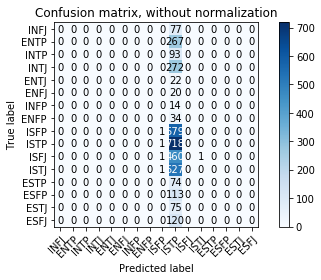

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from performance import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(test_Y, _predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(test_Y, _predictions, classes=class_names, normalize=True,
                      # title='Normalized confusion matrix')

plt.show()

#### Cross Validation

In [104]:
from sklearn.model_selection import cross_validate

np.random.seed(1)

scoring = {'acc': 'accuracy',
           'f1_micro': 'f1_micro'}

results = cross_validate(text_clf, train_X['preprocessed_posts'], train_Y, cv=5, 
                          scoring=scoring, n_jobs=-1)

In [105]:
# print(results)
print("Accuracy: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_acc']),
                                                          np.std(results['test_acc'])))

print("F1: {:0.4f} (+/- {:0.4f})".format(np.mean(results['test_f1_micro']),
                                                          np.std(results['test_f1_micro'])))


# Accuracy: 0.2140 (+/- 0.0004)
# F1: 0.2140 (+/- 0.0004)

# Preprocessed
# Accuracy: 0.2144 (+/- 0.0006)
# F1: 0.2144 (+/- 0.0006)

Accuracy: 0.2501 (+/- 0.0405)
F1: 0.2501 (+/- 0.0405)


#### SVM

In [22]:
from sklearn.linear_model import SGDClassifier

text_clf_svm = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(max_iter=1000, tol=1e-3)),
                    ])

text_clf_svm = text_clf_svm.fit(train['preprocessed_post'], train['type'])

predicted_svm = text_clf_svm.predict(test['preprocessed_post'])


print("Classes predicted: {}".format(np.unique( predicted_svm )))
print("Classes in test data: {}".format(np.unique( test['type'] )))
print()


print("Accuracy: {}".format(np.mean(predicted_svm == test['type'])))
print()

precision_svm, recall_svm, f_score_svm, support_svm = precision_recall_fscore_support(test['type'], predicted_svm, average='weighted')  # average="micro"||"macro"||"weighted"
print("Precision: {}".format(precision_svm))
print("Recall: {}".format(recall_svm))
print("F-beta score: {}".format(f_score_svm))

# default : 0.6585
# stop_words : 0.6571
# stop_words & preprocessed: 0.6591

Classes predicted: ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']
Classes in test data: ['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']

Accuracy: 0.20374135827572185

Precision: 0.19145228775050147
Recall: 0.20374135827572185
F-beta score: 0.19405997665688643


Confusion matrix, without normalization
[[  194   293    72   245    30    27    30    37   608  1038   286   494
     69    89    75   123]
 [  222  1977   197   878    63    76    57   124  1890  3615  1167  1728
    176   304   273   415]
 [   66   297   252   304    18    26    28    40   572  1050   532   750
     66   117   104   163]
 [  180   944   273  1732    81    74    91   130  1768  3133  1302  2486
    181   319   261   439]
 [   16    61    16    42    52     7     6    10   112   201    62   125
     18    26    12    25]
 [   11    89    20    75     6    32     4    16   133   225    76   134
     21    21     9    31]
 [   15    49    20    52     4     5    42     4   101   212    79   116
      6    23    15    30]
 [   26   117    34   151    12    17    11    76   238   411   145   279
     30    65    30    59]
 [  375  1805   446  1597   123   156   106   232  7265  8057  2287  3891
    380   683   497   803]
 [  463  2308   485  1865   155   214   132   248  

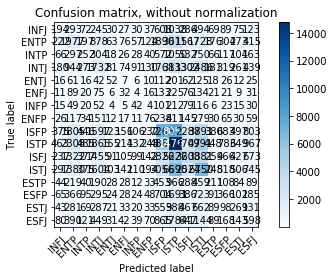

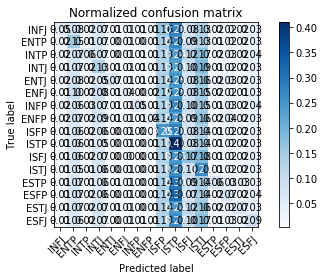

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from performance import plot_confusion_matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(test['type'], predicted_svm, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(test['type'], predicted_svm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()